# Extreme Gradient Boosted Trees

XGBoost is the primary implementation of gradient boosted trees used in Python. Here, we train a classifier on the Hearts disease dataset to predict whether a give patient has heart disease based on 13 attributes.


## Loading in the Data
First, we import all the necessary libraries as well as the data.

In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier, plot_importance
import xgboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [4]:
%matplotlib inline

In [5]:
df = pd.read_csv('cardio_train1.csv')
df.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [6]:
df.shape

(9999, 13)

We have 9999 observations, each with 13 attributes out of which are 12 are features and the last one is the result column.

In [7]:
df.describe()

id           age       gender       height       weight  \
count   9999.000000   9999.000000  9999.000000  9999.000000  9999.000000   
mean    7108.527853  19449.312331     1.345335   164.308331    74.304340   
std     4127.675620   2479.751490     0.475501     8.179194    14.566945   
min        0.000000  10878.000000     1.000000    70.000000    30.000000   
25%     3529.500000  17629.500000     1.000000   159.000000    65.000000   
50%     7079.000000  19699.000000     1.000000   165.000000    72.000000   
75%    10693.500000  21314.000000     2.000000   170.000000    82.000000   
max    14253.000000  23670.000000     2.000000   250.000000   200.000000   

              ap_hi         ap_lo  cholesterol         gluc        smoke  \
count   9999.000000   9999.000000  9999.000000  9999.000000  9999.000000   
mean     128.035804     97.954895     1.365037     1.222222     0.089009   
std      116.841395    207.208304     0.677682     0.565585     0.284771   
min     -100.000000      0.000000     1.000000     1.000000     0.000000   
25%      120.000000     80.000000     1.000000     1.000000     0.000000   
50%      120.000000     80.000000     1.000000     1.000000     0.000000   
75%      140.000000     90.000000     2.000000     1.000000     0.000000   
max    11500.000000  10000.000000     3.000000     3.000000     1.000000   

              alco      active       cardio  
count  9999.000000  9999.00000  9999.000000  
mean      0.053705     0.79718     0.503050  
std       0.225447     0.40212     0.500016  
min       0.000000     0.00000     0.000000  
25%       0.000000     1.00000     0.000000  
50%       0.000000     1.00000     1.000000  
75%       0.000000     1.00000     1.000000  
max       1.000000     1.00000     1.000000

## Exploratory Data Analysis

This is a necessary step to gauge the quality of the data. First, we need to check the value counts in the target column to make sure they aren't skewed towards one result.


In [8]:
df.cardio.value_counts() 

cardio
1    5030
0    4969
Name: count, dtype: int64

<BarContainer object of 2 artists>

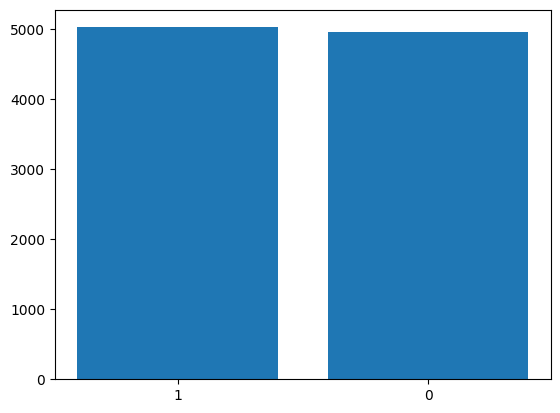

In [9]:
plt.bar(['1','0'], height=df.cardio.value_counts())

# DATA PREPROCESSING 

Checking for missing values , if any

In [10]:
missing_values = df.isnull().sum()


#### Creating a heatmap to visualize missing values

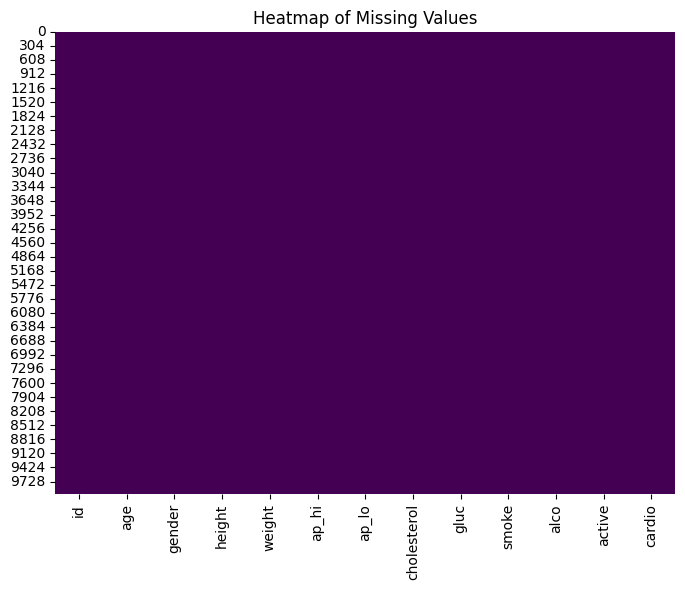

In [11]:
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')  # Customize the colormap if needed
plt.title('Heatmap of Missing Values')
plt.show()

There are no missing values.

### Metrics 'height', 'weight', 'age','ap_hi', 'ap_lo' undergoing normalization

In [12]:
scaler = MinMaxScaler()
df[['height', 'weight', 'age','ap_hi','ap_lo']] = scaler.fit_transform(df[['height', 'weight', 'age','ap_hi','ap_lo']])


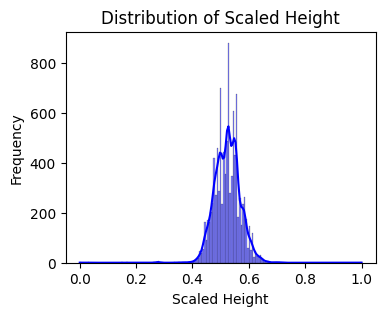

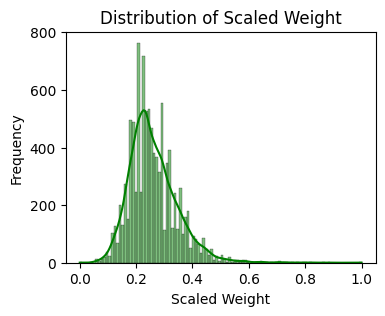

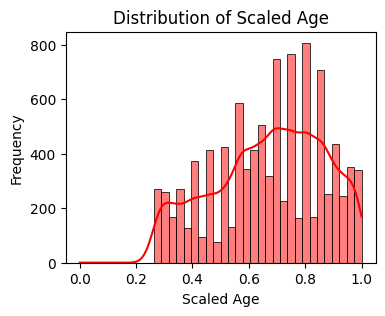

In [13]:
plt.figure(figsize=(4, 3))
sns.histplot(df['height'], kde=True, color='blue')
plt.title('Distribution of Scaled Height')
plt.xlabel('Scaled Height')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(4, 3))
sns.histplot(df['weight'], kde=True, color='green')
plt.title('Distribution of Scaled Weight')
plt.xlabel('Scaled Weight')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(4, 3))
sns.histplot(df['age'], kde=True, color='red')
plt.title('Distribution of Scaled Age')
plt.xlabel('Scaled Age')
plt.ylabel('Frequency')
plt.show()


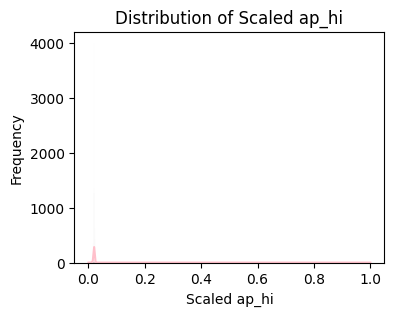

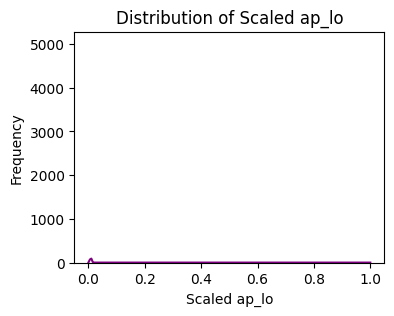

In [14]:
plt.figure(figsize=(4, 3))
sns.histplot(df['ap_hi'], kde=True, color='pink')
plt.title('Distribution of Scaled ap_hi')
plt.xlabel('Scaled ap_hi')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(4, 3))
sns.histplot(df['ap_lo'], kde=True, color='purple')
plt.title('Distribution of Scaled ap_lo')
plt.xlabel('Scaled ap_lo')
plt.ylabel('Frequency')
plt.show()

### Outlier Removal for Height, Weight and Age

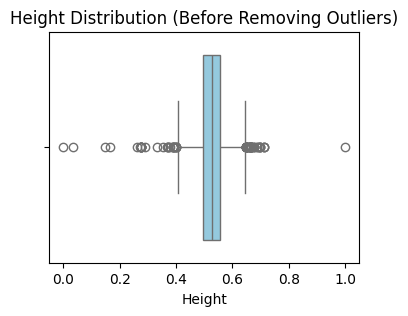

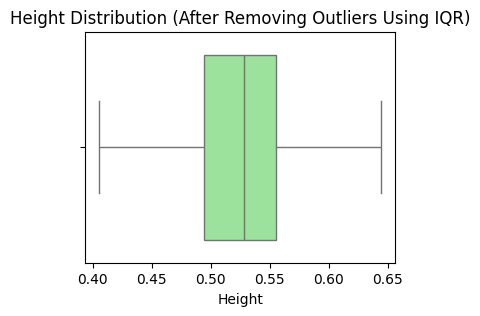

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Plot Height Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['height'], color='skyblue')
plt.title('Height Distribution (Before Removing Outliers)')
plt.xlabel('Height')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['height'].quantile(0.25)
Q3 = df['height'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers based on the IQR method
df_filtered_height_iqr = df[(df['height'] >= lower_bound) & (df['height'] <= upper_bound)]

# Plot Height Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered_height_iqr['height'], color='lightgreen')
plt.title('Height Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Height')
plt.show()



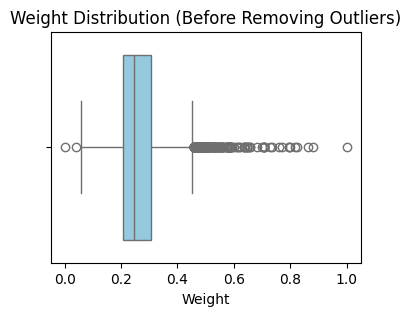

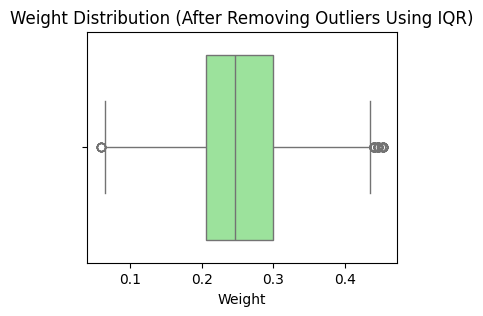

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt

# Plot Weight Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['weight'], color='skyblue')
plt.title('Weight Distribution (Before Removing Outliers)')
plt.xlabel('Weight')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Weight
Q1_weight = df['weight'].quantile(0.25)
Q3_weight = df['weight'].quantile(0.75)

# Calculate IQR (Interquartile Range) for Weight
IQR_weight = Q3_weight - Q1_weight

# Define lower and upper bounds for outliers in Weight data
lower_bound_weight = Q1_weight - 1.5 * IQR_weight
upper_bound_weight = Q3_weight + 1.5 * IQR_weight

# Filter out the outliers based on the IQR method for Weight
df_filtered_weight_iqr = df[(df['weight'] >= lower_bound_weight) & (df['weight'] <= upper_bound_weight)]

# Plot Weight Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered_weight_iqr['weight'], color='lightgreen')
plt.title('Weight Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Weight')
plt.show()



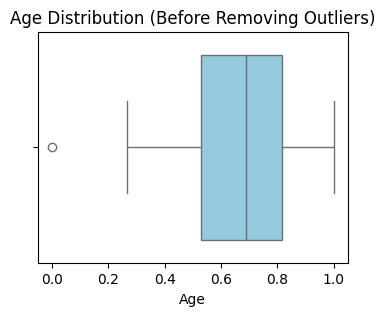

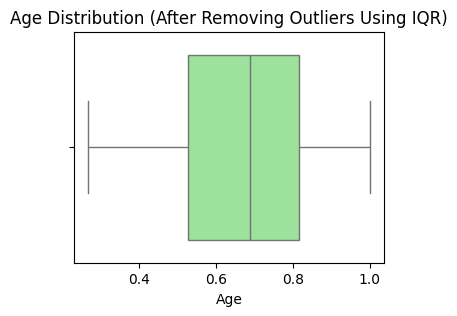

In [17]:

# Plot Age Distribution Before Removing Outliers
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Age Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['age'], color='skyblue')
plt.title('Age Distribution (Before Removing Outliers)')
plt.xlabel('Age')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Age
Q1_age = df['age'].quantile(0.25)
Q3_age = df['age'].quantile(0.75)

# Calculate IQR (Interquartile Range) for Age
IQR_age = Q3_age - Q1_age

# Define lower and upper bounds for outliers in Age data
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

# Filter out the outliers based on the IQR method for Age
df_filtered_age_iqr = df[(df['age'] >= lower_bound_age) & (df['age'] <= upper_bound_age)]

# Plot Age Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered_age_iqr['age'], color='lightgreen')
plt.title('Age Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Age')
plt.show()


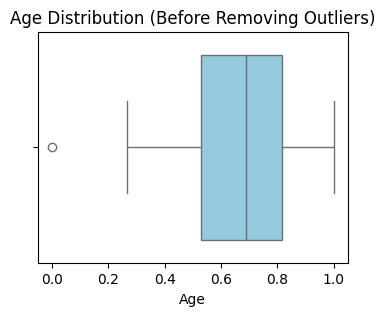

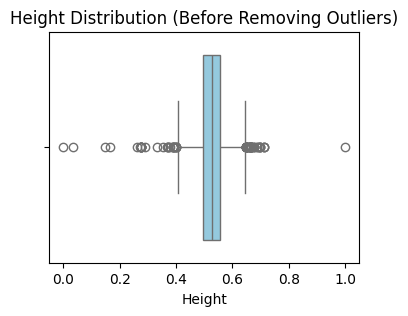

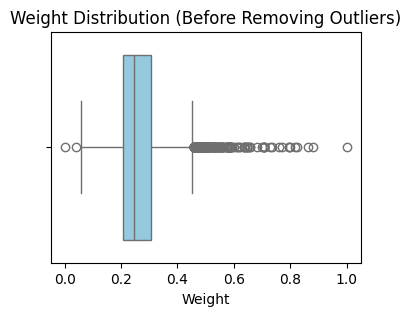

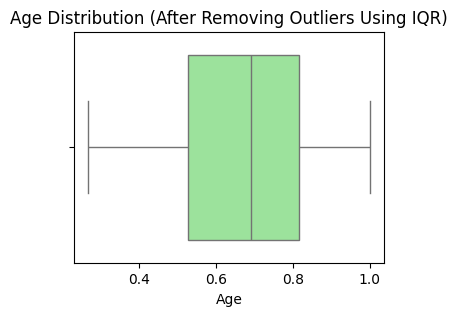

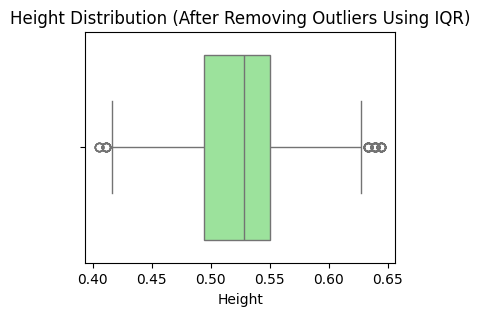

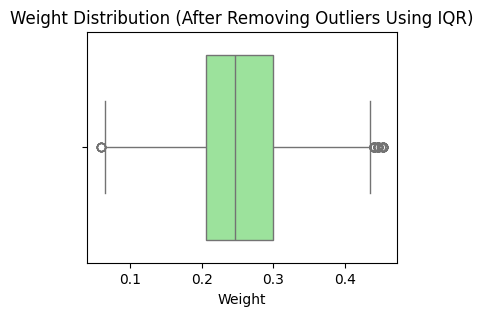

         id       age  gender    height    weight     ap_hi  ap_lo  \
0         0  0.587477       2  0.544444  0.188235  0.018103  0.008   
1         1  0.730926       1  0.477778  0.323529  0.020690  0.009   
2         2  0.623749       1  0.527778  0.200000  0.019828  0.007   
3         3  0.527283       2  0.550000  0.305882  0.021552  0.010   
4         4  0.515635       1  0.477778  0.152941  0.017241  0.006   
...     ...       ...     ...       ...       ...       ...    ...   
9994  14247  0.807770       1  0.466667  0.311765  0.021552  0.009   
9995  14249  0.746482       1  0.533333  0.205882  0.019828  0.008   
9996  14251  0.573483       1  0.500000  0.370588  0.020690  0.008   
9997  14252  0.296044       1  0.488889  0.211765  0.019828  0.009   
9998  14253  0.582395       1  0.544444  0.235294  0.022414  0.008   

      cholesterol  gluc  smoke  alco  active  cardio  
0               1     1      0     0       1       0  
1               3     1      0     0       1     

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame

# Plot Age Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['age'], color='skyblue')
plt.title('Age Distribution (Before Removing Outliers)')
plt.xlabel('Age')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Age
Q1_age = df['age'].quantile(0.25)
Q3_age = df['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

# Plot Height Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['height'], color='skyblue')
plt.title('Height Distribution (Before Removing Outliers)')
plt.xlabel('Height')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Height
Q1_height = df['height'].quantile(0.25)
Q3_height = df['height'].quantile(0.75)
IQR_height = Q3_height - Q1_height
lower_bound_height = Q1_height - 1.5 * IQR_height
upper_bound_height = Q3_height + 1.5 * IQR_height

# Plot Weight Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['weight'], color='skyblue')
plt.title('Weight Distribution (Before Removing Outliers)')
plt.xlabel('Weight')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Weight
Q1_weight = df['weight'].quantile(0.25)
Q3_weight = df['weight'].quantile(0.75)
IQR_weight = Q3_weight - Q1_weight
lower_bound_weight = Q1_weight - 1.5 * IQR_weight
upper_bound_weight = Q3_weight + 1.5 * IQR_weight

# Filter out the outliers for Age, Height, and Weight using IQR method
df_filtered = df[
    (df['age'] >= lower_bound_age) & (df['age'] <= upper_bound_age) &
    (df['height'] >= lower_bound_height) & (df['height'] <= upper_bound_height) &
    (df['weight'] >= lower_bound_weight) & (df['weight'] <= upper_bound_weight)
]

# Plot Age Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered['age'], color='lightgreen')
plt.title('Age Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Age')
plt.show()

# Plot Height Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered['height'], color='lightgreen')
plt.title('Height Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Height')
plt.show()

# Plot Weight Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered['weight'], color='lightgreen')
plt.title('Weight Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Weight')
plt.show()

# Display the filtered DataFrame
print(df_filtered)



In [19]:
df_filtered.describe()

id          age       gender       height       weight  \
count   9689.000000  9689.000000  9689.000000  9689.000000  9689.000000   
mean    7117.005057     0.670425     1.342141     0.523480     0.253705   
std     4127.671189     0.193976     0.474451     0.042052     0.073425   
min        0.000000     0.267276     1.000000     0.405556     0.058824   
25%     3546.000000     0.527752     1.000000     0.494444     0.205882   
50%     7090.000000     0.689884     1.000000     0.527778     0.247059   
75%    10711.000000     0.816526     2.000000     0.550000     0.300000   
max    14253.000000     1.000000     2.000000     0.644444     0.452941   

             ap_hi        ap_lo  cholesterol         gluc        smoke  \
count  9689.000000  9689.000000  9689.000000  9689.000000  9689.000000   
mean      0.019635     0.009719     1.359273     1.219321     0.087625   
std       0.010226     0.020792     0.672416     0.562647     0.282764   
min       0.000000     0.000000     1.000000     1.000000     0.000000   
25%       0.018966     0.008000     1.000000     1.000000     0.000000   
50%       0.018966     0.008000     1.000000     1.000000     0.000000   
75%       0.020690     0.009000     1.000000     1.000000     0.000000   
max       1.000000     1.000000     3.000000     3.000000     1.000000   

              alco       active       cardio  
count  9689.000000  9689.000000  9689.000000  
mean      0.053153     0.797193     0.497987  
std       0.224350     0.402111     0.500022  
min       0.000000     0.000000     0.000000  
25%       0.000000     1.000000     0.000000  
50%       0.000000     1.000000     0.000000  
75%       0.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000

In [20]:
df_filtered.shape

(9689, 13)

### Feature Selection Using XG Boost

<Figure size 1000x600 with 0 Axes>

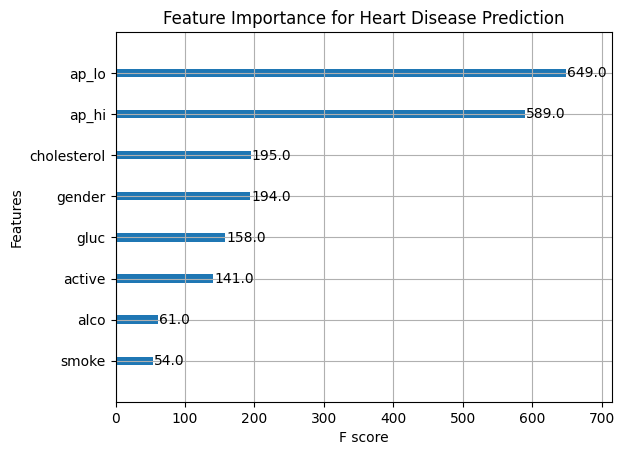

In [21]:
# Define features and target variable
Z = df_filtered[['gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]  # Features as per your parameters
y = df_filtered['cardio']  # Target variable

# Train the XGBoost model
model = XGBClassifier()
model.fit(Z, y)

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='weight', max_num_features=14, title='Feature Importance for Heart Disease Prediction', xlabel='F score', ylabel='Features')
plt.show()

We have got our most 6 importrant features :-weight,ap_hi, ap_lo, cholesterol, gluc,active

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


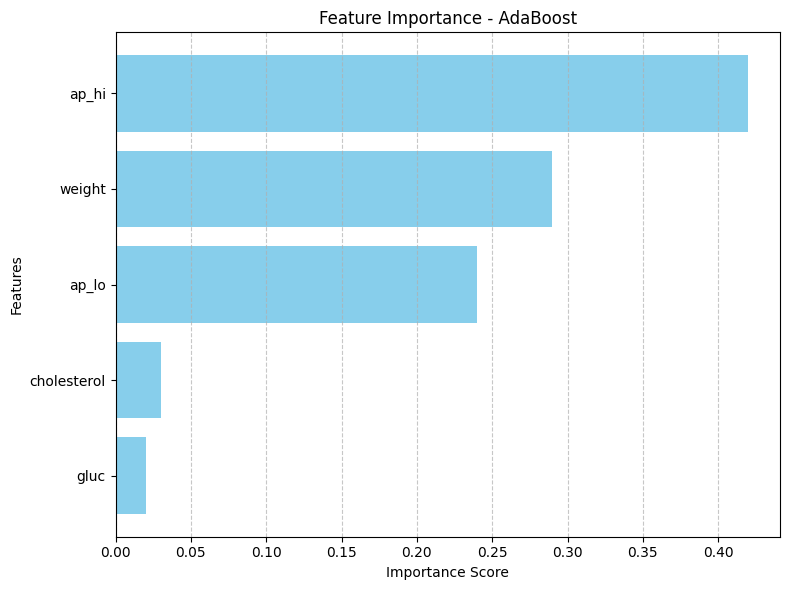

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve



X = df_filtered[['weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']]  # Feature set
y = df_filtered['cardio']  # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

base_estimator = DecisionTreeClassifier(max_depth=1)  # Shallow trees (decision stumps)
ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)


ada_model.fit(X_train, y_train)


y_pred = ada_model.predict(X_test)  # Class predictions
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

feature_importances = ada_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
features = X_train.columns  # Feature names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance - AdaBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Model Training


### XG Boost Classifier


In [23]:
df_filtered.describe()

id          age       gender       height       weight  \
count   9689.000000  9689.000000  9689.000000  9689.000000  9689.000000   
mean    7117.005057     0.670425     1.342141     0.523480     0.253705   
std     4127.671189     0.193976     0.474451     0.042052     0.073425   
min        0.000000     0.267276     1.000000     0.405556     0.058824   
25%     3546.000000     0.527752     1.000000     0.494444     0.205882   
50%     7090.000000     0.689884     1.000000     0.527778     0.247059   
75%    10711.000000     0.816526     2.000000     0.550000     0.300000   
max    14253.000000     1.000000     2.000000     0.644444     0.452941   

             ap_hi        ap_lo  cholesterol         gluc        smoke  \
count  9689.000000  9689.000000  9689.000000  9689.000000  9689.000000   
mean      0.019635     0.009719     1.359273     1.219321     0.087625   
std       0.010226     0.020792     0.672416     0.562647     0.282764   
min       0.000000     0.000000     1.000000     1.000000     0.000000   
25%       0.018966     0.008000     1.000000     1.000000     0.000000   
50%       0.018966     0.008000     1.000000     1.000000     0.000000   
75%       0.020690     0.009000     1.000000     1.000000     0.000000   
max       1.000000     1.000000     3.000000     3.000000     1.000000   

              alco       active       cardio  
count  9689.000000  9689.000000  9689.000000  
mean      0.053153     0.797193     0.497987  
std       0.224350     0.402111     0.500022  
min       0.000000     0.000000     0.000000  
25%       0.000000     1.000000     0.000000  
50%       0.000000     1.000000     0.000000  
75%       0.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000

Accuracy: 0.7282
AUC: 0.7765


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:56:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


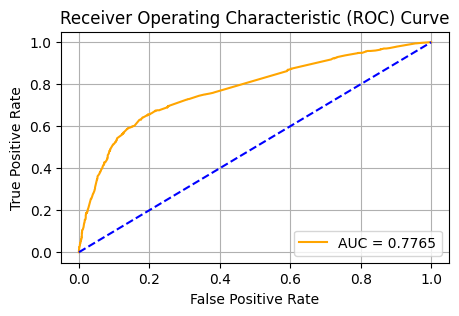

In [24]:
# Step 2: Select only the most important features
X = df_filtered[['ap_hi','ap_lo','cholesterol','active','gender'
]]
y = df_filtered['cardio']  # The target variable

# Step 3: Split the dataset (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Step 4: Initialize the XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Step 5: Train the model
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Heart Disease)

# Step 7: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Step 8: Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

# Step 9: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='orange', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Ada Boost Classifier


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.7286
AUC: 0.7796


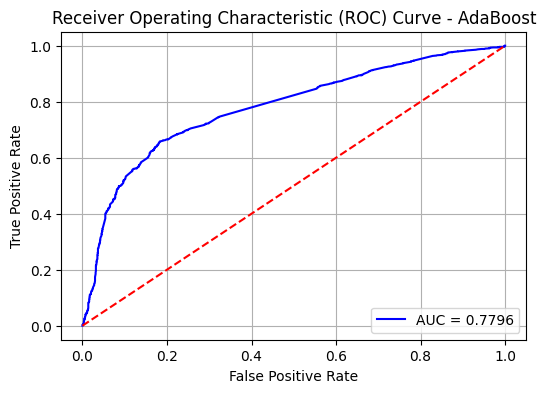

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Step 1: Load the dataset
# Assuming 'df_filtered' is your DataFrame
# Example: df_filtered = pd.read_csv('path_to_your_file.csv')

# Step 2: Select features and target variable
X = df_filtered[['weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']]  # Feature set
y = df_filtered['cardio']  # Target variable

# Step 3: Split the dataset (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Step 4: Initialize the AdaBoost Classifier with DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)  # Shallow trees (decision stumps)
ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)

# Step 5: Train the AdaBoost model
ada_model.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = ada_model.predict(X_test)  # Class predictions
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Step 7: Evaluate the model
# Calculate accuracy and AUC
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'AUC: {auc:.4f}')

# Step 8: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('Receiver Operating Characteristic (ROC) Curve - AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




### Comparing XG Boost Classsifier and Ada Boost classifier

XG Boost Classifier

In [26]:
# Load your dataset
# Assuming your dataset is already loaded and cleaned with the important features selected
# Replace df with your actual DataFrame
# df = pd.read_csv('your_dataset.csv')

Z = df_filtered[['ap_hi','ap_lo','cholesterol','active','gender']]
y = df_filtered['cardio']  # The target variable


# Split the dataset into training (70%) and testing (30%)
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.3, random_state=42, stratify=y)

# Initialize models

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42, use_label_encoder=False)


# Train the XGBoost model
xgb_model.fit(Z_train, y_train)
y_pred_xgb = xgb_model.predict(Z_test)



print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))



Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1459
           1       0.79      0.62      0.69      1448

    accuracy                           0.73      2907
   macro avg       0.74      0.73      0.72      2907
weighted avg       0.74      0.73      0.72      2907



c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:56:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ada Boost Classifier

In [27]:
X = df_filtered[['weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']]  # Feature set
y = df_filtered['cardio']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Initialize models
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
# Train the AdaBoost model
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
# Print classification report for both models
print("Classification Report for AdaBoost:")
print(classification_report(y_test, y_pred_ada))


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      1459
           1       0.77      0.64      0.70      1448

    accuracy                           0.73      2907
   macro avg       0.73      0.73      0.72      2907
weighted avg       0.73      0.73      0.72      2907



In [28]:

# Compute AUC for Ada
roc_auc_ada = roc_auc_score(y_test, ada_model.predict_proba(X_test)[:, 1])
print(f"AdaBoost ROC AUC: {roc_auc_ada}")





AdaBoost ROC AUC: 0.776793828740642


In [29]:
#Complete  AUC for XG Boost
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(Z_test)[:, 1])
print(f"XGBoost ROC AUC: {roc_auc_xgb}")

XGBoost ROC AUC: 0.7778155400467286


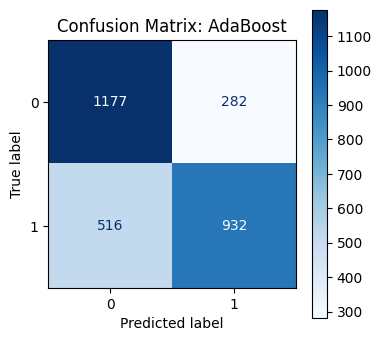

In [30]:
# Plot confusion matrix for AdaBoost
plt.figure(figsize=(4,4))
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
disp_ada = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ada)
disp_ada.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix: AdaBoost')
plt.show()


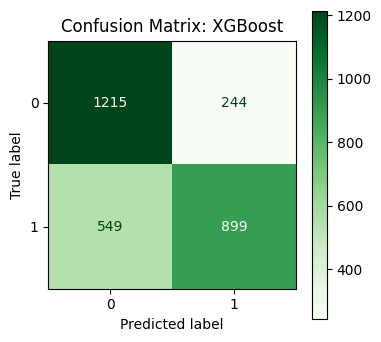

In [31]:

plt.figure(figsize=(4,4))
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
disp_xgb.plot(cmap='Greens', ax=plt.gca())
plt.title('Confusion Matrix: XGBoost')
plt.show()



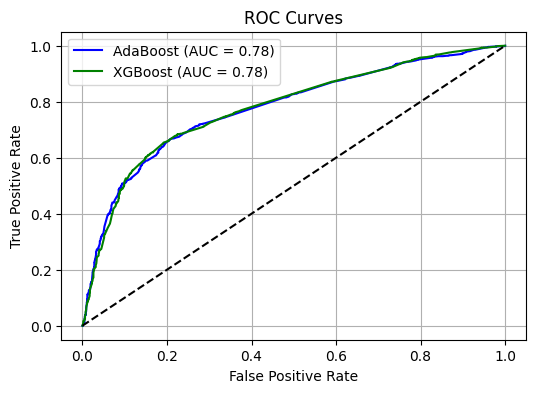

In [32]:

fpr_ada, tpr_ada, _ = roc_curve(y_test, ada_model.predict_proba(X_test)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(Z_test)[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(fpr_ada, tpr_ada, label=f'AdaBoost (AUC = {roc_auc_ada:.2f})', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Tuning

XG Boost Tuning


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('cardio_train1.csv')

# Step 2: Select only the most important features
Z = df_filtered[['ap_hi','ap_lo','cholesterol','active','gender'
]]
y = df_filtered['cardio']  # The target variable

# Split the data into training and testing sets
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier with tuned parameters
tuned_model = xgb.XGBClassifier(
    gamma=3,
    learning_rate=0.05,
    eval_metric='error' 
)

# Train the model
tuned_model.fit(    Z_train, y_train)

# Evaluate the training accuracy
train_accuracy = accuracy_score(tuned_model.predict(Z_train), y_train)
print("Training accuracy: ", train_accuracy)

# Make predictions on the test set
y_pred_tuned = tuned_model.predict(Z_test)

# Evaluate the test accuracy
test_accuracy = accuracy_score(y_pred_tuned, y_test)
print("Test accuracy: ", test_accuracy)



Training accuracy:  0.7289382015223842
Test accuracy:  0.7208462332301342


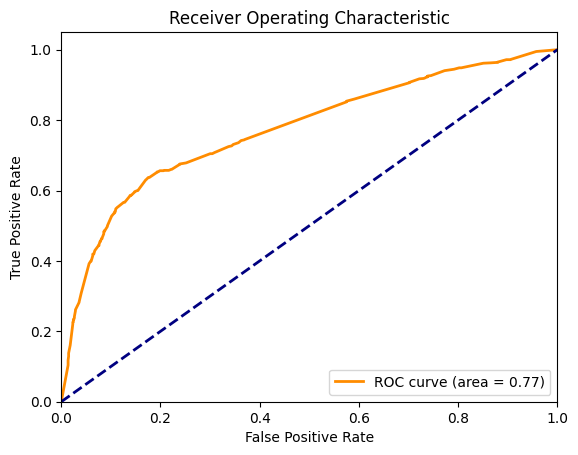

In [34]:
y_proba = tuned_model.predict_proba(Z_test)[:, 1]


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()